# Image Classification Model Training with TensorFlow in Sagemaker

This tutorial shows you how to train an image classification model that can be deployed onto our FireFly-DL cameras. We use SageMaker as our training environment, which allows users to train a model on AWS’s cloud platform. In this tutorial we use the Flowers dataset as an example dataset to train a model that can classify five different types of flowers. In addition, you can upload your own dataset to your S3 bucket and train your classification model.





## Import Libraries

First, we import Sagemaker and several other python libraries needed in this tuturial.

In [6]:
%matplotlib inline

# AWS SageMaker python SDK
import sagemaker

# Additionl libraries
import numpy as np
import random
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import urllib
import boto3


print('Libraries imported')

Libraries imported


## Setup
We will set up a few things before starting the workflow.
1.	Create your cloud storage bucket on S3 and assign the name to the variable bucket_name in the code block below.
2.	Get the execution role for accessing your AWS resources.


In [7]:
bucket_name = 'flowerdataset' # MUST PROVIDE BUCKET NAME

# check if bucket exists
s3 = boto3.client('s3')
response = s3.list_buckets()
buckets = [bucket['Name'] for bucket in response['Buckets']]

if bucket_name not in buckets:
    print(f' S3 bucket name "{bucket_name}" does not exists.')
else:
    print(f' S3 bucket name "{bucket_name}" found.')
    
sess = sagemaker.Session() # initiolize a sagemaker session
role = sagemaker.get_execution_role() # we are using the notebook instance role for training in this example

 S3 bucket name "flowerdataset" found.


---

## Option 1: Flowers Dataset 

Here we provide an example image dataset of five different types of flowers. This section is optional, and if you have your own dataset you can skip ahead to Option 2.

### 1. Download and Extract Flower Dataset
As an example; we will use the Oxford Flowers dataset to train our model. This dataset can be downloaded from the following link http://download.tensorflow.org/example_images/flower_photos.tgz.
The flower images are annotated using the parent directory name, and are split between five classes/folders according to the flower type:
1. Daisy
2. Sunflowers
3. Roses
4. Tulips
5. Dandelion

The following code downloads the flower photos and extracts the content to the *'/flower_photos'* directory in your current Jupyter notebook instance.
current Jupyter notebook instance.

In [178]:
def download_and_extract(url, data_dir, download_dir):
    target_file = url.split('/')[-1]
    if target_file not in os.listdir(download_dir):
        print('Downloading', url)
        urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
        tf = tarfile.open(url.split('/')[-1])
        tf.extractall(data_dir)
    else:
        print('Already downloaded', url)

In [181]:
image_dir = 'flower_photos' # Path to image directory folder. This must point to parent directery of the class folders.

flowers_url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
download_and_extract(flowers_url, './', '.')

Already downloaded http://download.tensorflow.org/example_images/flower_photos.tgz


### 2. Visulization Flower Dataset

The code below loops over the downloaded image dataset and randomly display’s some the images from the dataset.

In [182]:
import glob
dirs = [f for f in os.listdir(image_dir) if '.txt' not in f]
print('list of class labels', dirs)


list of class labels ['tulips', 'daisy', 'dandelion', 'roses', 'sunflowers']


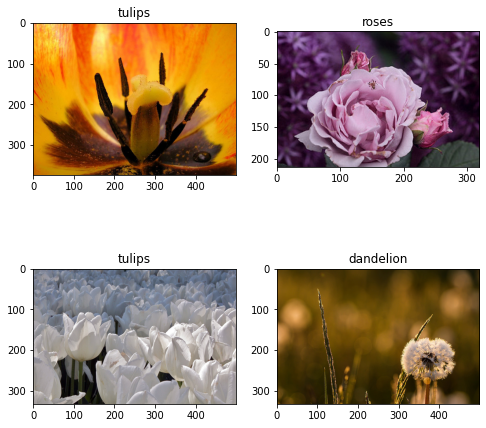

In [183]:
# create list of all images
file_list = list()
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith('.jpg'):
            #print(root, file)
            file_list.append((root,file))


fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 2

for i in range(1, columns*rows +1):
    img_path =random.choice([os.path.join(root,file) for root, file in file_list])
    img = Image.open(img_path, 'r').convert('RGB')
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(img_path.split('/')[-2])
    plt.imshow(img)


### 3. Upload Training Images to Your S3 bucket

Next, we upload the training images to your S3 cloud storage bucket.


In [184]:
# Get a list of all bucket names from the response
s3 = boto3.client('s3')
response = s3.list_buckets()
buckets = [bucket['Name'] for bucket in response['Buckets']]

if bucket_name in buckets:
    print('Uploading data to S3')
    response = s3.list_objects_v2(
                Bucket=bucket_name,
                Prefix =image_dir,
                MaxKeys=10)
    # print(response)
    if 'Contents' not in list(response.keys()):
        s3_data_path = sess.upload_data(path=image_dir, bucket=bucket_name, key_prefix=image_dir)
    else:
        s3_data_path = f's3://{bucket_name}/{image_dir}' 
    print('Uploaded to', s3_data_path)
else:
    print(f' S3 bucket name "{bucket_name}" does not exists.')


Uploading data to S3
Uploaded to s3://flowerdataset/flower_photos


You can skip Option 2 if you wish and go directly to *Train with TensorFlow Estimator* section if you want to train the model on the flowers dataset.

---

## Option 2: Prepare and Upload Your Own Images

### 1. Collect Your Own Data

First, you must collect and label some images that you would like to use to train the classification model on. 
1. Collect training images. 
    * The train.py script only supports the following image formats *'jpg', 'jpeg', 'png', and 'bmp'*.


2. Label the images into classes using the parent directory name.
    * Each image most be save into only one folder (representing the class)
    * The ground-truth label for each image is taken from the parent directory name.


### 2. Upload Training Images to Your S3 Bucket
 
Next, upload your training images directly to the S3 bucket.
1.	Create a folder (*image_dir*) inside your S3 bucket (*bucket_name*).
2.	All the class folder (e.g. class_1, class_2 ...), which contain the images must be uploaded under the *image_dir* folder.

**Important Note:**
Verify that the bucket (*bucket_name*) and image folder (*image_dir*) variable names match the S3 bucket and image folder names, where your images were uploaded to. The above diagram shows the expected S3 image folder and file structure.


In [8]:
image_dir = 'flower_photos' # MUST PROVIDE CORRECT IMAGE FOLDER NAME

s3_data_path = f's3://{bucket_name}/{image_dir}' 
print('s3 image path', s3_data_path)

s3 image path s3://flowerdataset/flower_photos


3.	Run the next code block to check your S3 bucket folder structure is correct. If the folder structure is correct, the code output's a list of classes and the number of images per class.

In [5]:

# Get a list of all bucket names from the response
def check_s3_response(response, dic):
    if 'correct_image_format' not in dic.keys() and 'wrong_image_format' not in dic.keys():
        dic = {'correct_image_format':{}, 'wrong_image_format':list()}
        
    for key in response['Contents']:
#         print(key['Key'].split('/'))
        # Create file path list
        file_path_list = key['Key'].split('/')
        # check images
        if len(file_path_list) > 2:
            if file_path_list[-1].split('.')[1] in ['jpg', 'jpeg', 'png','bmp']:
                # check class exists and append image to list
                if file_path_list[-2] not in dic['correct_image_format'].keys():
                    dic['correct_image_format'][file_path_list[-2]] = list()
                dic['correct_image_format'][file_path_list[-2]].append(file_path_list[-1])
            else:
                dic['correct_image_format'].append('/'.join(file_path_list))
    return dic

print(f"Scanning S3 bucket '{s3_data_path}' for images \n")

# Get a list of all bucket names from the response
s3 = boto3.client('s3')
response = s3.list_buckets()
buckets = [bucket['Name'] for bucket in response['Buckets']]

if bucket_name in buckets:
    response = s3.list_objects_v2(
                Bucket=bucket_name,
                Prefix =image_dir,
                MaxKeys=1000)
    # print(response)
    if 'Contents' in list(response.keys()):
        dic = {}
        dic = check_s3_response(response, dic)    
        while(response['IsTruncated']):
            response = s3.list_objects_v2(
                    Bucket=bucket_name,
                    Prefix=image_dir,
                    ContinuationToken=response['NextContinuationToken'],
                    MaxKeys=1000)
        #         print(response)         
            dic = check_s3_response(response, dic)
        print(f"Class folders found in {image_dir} {list(dic['correct_image_format'].keys())}")
        print('Number of images found in each class')
        for class_dir in dic['correct_image_format'].keys():
            num_images = len(dic['correct_image_format'][class_dir])
            print(f'{class_dir}: {num_images}')
    else:
        s3_data_path = ''
        print(f"'{image_dir}' does not exists in '{bucket_name}' s3 bucket")
        
else:
    print(f' S3 bucket name "{bucket_name}" does not exists.')
    s3_data_path = ''

print('\n')
print(f'S3 image path set to {s3_data_path}')

## TODO:  Visulize random samples of the images

Scanning S3 bucket 's3://flowerdataset/flower_photos' for images 

Class folders found in flower_photos ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Number of images found in each class
daisy: 633
dandelion: 898
roses: 641
sunflowers: 699
tulips: 799


S3 image path set to s3://flowerdataset/flower_photos


---

## Building and Registering A Docker container

With Amazon SageMaker, you can package an algorithm that can than be trained and deployed in the SageMaker environment. This section will guide you through the process of building a Docker container for SageMaker and using it for training and inference.

The shell code below first creates a privet ECR repository if the repository doesn't exist under your default region. Then, it uses the `dockerfile` to build the training docker images and push's that image to your ECR repository.

In [134]:
%%sh

# Specify an ecr image name
ecr_image_name=tensorflow_image_classifier_1

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
# region=$(aws configure get region)
region=${region:-us-west-2}

ecr_image_fullname="${account}.dkr.ecr.${region}.amazonaws.com/${ecr_image_name}:latest"

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${ecr_image_name}" > /dev/null 2>&1
if [ $? -ne 0 ]
then
aws ecr create-repository --repository-name "${ecr_image_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.
sudo chown -R $USER .
docker build -f Dockerfile -t ${ecr_image_name} .
docker tag ${ecr_image_name} ${ecr_image_fullname}

docker push ${ecr_image_fullname}

Login Succeeded
Sending build context to Docker daemon  25.99MB
Step 1/7 : FROM asigiuk/tf1.13-ncsdk-gpu-runtime:latest
 ---> a95e4b4ff51b
Step 2/7 : RUN pip install sagemaker-training
 ---> Running in 7a880a26dc67
     |████████████████████████████████| 47 kB 2.9 MB/s eta 0:00:011
     |████████████████████████████████| 131 kB 14.4 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 50.7 MB/s eta 0:00:0101
     |████████████████████████████████| 206 kB 48.1 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 43.1 MB/s eta 0:00:01
     |████████████████████████████████| 961 kB 49.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.7 MB 47.8 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 3.3 MB/s  eta 0:00:01
     |████████████████████████████████| 402 kB 42.1 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 58.4 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 9.5 MB/s  eta 0:00:01
     |█████████████████████

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



---

## Algorithm Resource


We can create an algorithm resource using the docker image created in the previous step. This algorithm resource defines the reference docker image, parameters, and settings for your training job. The algorithm can then be used to lunch multiple training jobs. You will only need to create this algorithm once and it will automatically be saved under your Amazon SageMaker account.

1. Define algorithm 

In [135]:
from src.training_specification import TrainingSpecification
from src.training_channels import TrainingChannels
from src.metric_definitions import MetricDefinitions
from src.tuning_objectives import TuningObjectives
import json

account = sess.boto_session.client("sts").get_caller_identity()["Account"]
region = sess.boto_session.region_name
ecr_image = "{}.dkr.ecr.{}.amazonaws.com/tensorflow_image_classifier_1:latest".format(account, region)

training_specification = TrainingSpecification().get_training_specification_dict(
    ecr_image=ecr_image,
    supports_gpu=True,
    supported_channels=[
        TrainingChannels(
            "train",
            description="Input channel that provides training data",
            supported_content_types=["png"],
        )
    ],
    supported_metrics=[MetricDefinitions("Loss", "loss:(.*?);")],
    supported_tuning_job_objective_metrics=[TuningObjectives("Minimize", "Loss")],
)

# print(json.dumps(training_specification, indent=2, sort_keys=True))

2. Create algorithm

In [136]:
import json
import time
import boto3

smmp = boto3.client("sagemaker")

algorithm_name = "tensorflow-image-classifier-algorithm-2"

create_algorithm_input_dict = {
    "AlgorithmName": algorithm_name,
    "AlgorithmDescription": "Image classification training algorihtm for FireFly-DL",
    "CertifyForMarketplace": False,
}
create_algorithm_input_dict.update(training_specification)

print("Now creating an algorithm in SageMaker")

smmp.create_algorithm(**create_algorithm_input_dict)

while True:
    response = smmp.describe_algorithm(AlgorithmName=algorithm_name)
    status = response["AlgorithmStatus"]
    print(status)
    if status == "Completed" or status == "Failed":
        break
    time.sleep(5)

Now creating an algorithm in SageMaker
Pending
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed


## Start a training job

Once the training algorithm has succefully been created. We can start training a classification model using either 
1. Option 1: AWS SageMaker console (Recommended).
2. Option 2: SageMaker Python API using this notebook instance.

---

### Option 1: Using AWS Console

1. On your SageMaker console, navigate to the `Trining > algorihtms` tab on the left side of the console. Under My `Algorithms` You should see the recently created algorithm `tensorflow-image-classifier-algorithm` in the list as shown the image below. 

![Select_Algo](https://github.com/FLIR/amazon-sagemaker-firefly-dl/blob/main/images/train_job_select_algo.PNG?raw=true)

2. Select this training job and under the `Action` tab select `Create training job`.

![Start_Train](https://github.com/FLIR/amazon-sagemaker-firefly-dl/blob/main/images/start_train_job.PNG?raw=true)

3. A new window will appear. Choose a name for the training job.

![Image of Yaktocat](https://github.com/FLIR/amazon-sagemaker-firefly-dl/blob/main/images/train_job_name.PNG?raw=true)

4. Under resource configureation. Select the `ml-p2-xlarge` instance type.

![Image of Yaktocat](https://github.com/FLIR/amazon-sagemaker-firefly-dl/blob/main/images/train_job_resources.PNG?raw=true)

5. Next, configure the hyperparameter settings. You can leave the defaults hyperparameter settings and still get good results. You can also experiment with the number of trainable layers and model name to improve the model performance.

![Image of Yaktocat](https://github.com/FLIR/amazon-sagemaker-firefly-dl/blob/main/images/train_job_hparameters.PNG?raw=true)

6.Under the input data configuration channels provide the S3 training image path. Leave the reset the setting as the default.

![Image of Yaktocat](https://github.com/FLIR/amazon-sagemaker-firefly-dl/blob/main/images/train_job_input.PNG?raw=true)

7. Output data configuration. provide the S3 bucket path where you want to save training output files.

![Image of Yaktocat](https://github.com/FLIR/amazon-sagemaker-firefly-dl/blob/main/images/train_job_output.PNG?raw=true)

8. Finaly, click Create training job.

---

<!-- ![Image of Yaktocat](https://github.com/FLIR/amazon-sagemaker-firefly-dl/blob/main/images/start_train_job.PNG?raw=true) -->

### Option 2: Using SageMaker API

#### Hyperparameter setting 

Specify the Hyperparameters for the training job. Note that the default parameters generally work very well and give good results. Below is a list of available hyperparameters.

- batch_size: The number of samples in each batch.
- num_of_trainable_layers: Number of trainable layers, options 1, 2, 3 or 4 layers. By default, only one layer is trained.
- max_number_of_steps: The maximum number of training steps.
- apply_image_augmentation: Enable random image augmentation during preprocessing for training. Below augmentation flags are only enabled if this flag is enabled.
    - random_image_flip: Enable random image flip (horizontally).
    - random_image_crop: Enable random cropping of images. 
    - min_object_cover: Fraction of whole image remaining after cropping.
    - random_image_rotation: Enable random image rotation counter-clockwise by 90, 180, 270, or 360 degrees.
    - random saturation, contrast, and brightness augmentation is applied by default.
- learning_rate: Initial learning rate.
- model_name: The name of the architecture to train, one of, mobilenet_v1_075, mobilenet_v1_050, mobilenet_v1_025, mobilenet_v1, inception_v1.
- optimizer: The name of the optimizer, one of adadelta, adagrad, adam, ftrl, momentum, sgd or rmsprop.

In [131]:
# JSON encode hyperparameters.
def json_encode_hyperparameters(hyperparameters):
    return {str(k): json.dumps(v) for (k, v) in hyperparameters.items()}

hyperparameters= json_encode_hyperparameters({"model_name":'mobilenet_v1', 
                    "max_number_of_steps":100, 
                    "learning_rate":0.01, 
                    "batch_size":16, 
                    "num_of_trainable_layers":2,})

hyperparameters = {"model_name":'mobilenet_v1', 
                    "max_number_of_steps":100, 
                    "learning_rate":0.01, 
                    "batch_size":16, 
                    "num_of_trainable_layers":2}

In [71]:
import sagemaker
from sagemaker.estimator import Estimator

estimator = Estimator(image_uri=ecr_image,
                      role=role,
                      base_job_name='tf-custom-container-test-job',
                      instance_count=1,
                      instance_type='ml.p2.xlarge')

# start training
#estimator.fit()

In [72]:
estimator.fit('s3://flowerdataset/flower_small/')

2021-10-05 11:39:01 Starting - Starting the training job...
2021-10-05 11:39:24 Starting - Launching requested ML instancesProfilerReport-1633433940: InProgress
...
2021-10-05 11:39:57 Starting - Preparing the instances for training............
2021-10-05 11:41:49 Downloading - Downloading input data...
2021-10-05 11:42:25 Training - Downloading the training image..................
2021-10-05 11:45:33 Training - Training image download completed. Training in progress...2021-10-05 11:45:39,784 sagemaker-training-toolkit INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": null,
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {},
    "input_config_dir": "/opt/ml/input/config",
    "input_data_config": {
        "training": {
            "TrainingInputMode": "File",
            "S3DistributionType": "

We create an ` AlgorithmEstimator` object and define the train job configuration:

* Algorithm_arn. Amazon Resource Name (ARN) or the name of the algorithm.
* Role. As defined above.
* Instance count which is the number of machines to use for training.
* Instance type which is the type of machine to use for training.
* Output path determines where the model artifact will be written.
* Hyperparameters: List of available hyperparameters are give above.

Then we use fit() on the estimator to train against the data that we uploaded above.

In [137]:
from sagemaker import AlgorithmEstimator
# data_path = os.path.join(DATA_DIR, 'marketplace', 'training')

algo = AlgorithmEstimator(
        algorithm_arn='tensorflow-image-classifier-algorithm-2',#algorithm_name,
        role=role,
        instance_count=1,
        hyperparameters=hyperparameters,
        output_path=f's3://{bucket_name}',
        instance_type='ml.p2.xlarge')

In [138]:
algo.fit({'train':s3_data_path})

2021-10-05 18:18:54 Starting - Starting the training job...
2021-10-05 18:19:17 Starting - Launching requested ML instancesProfilerReport-1633457934: InProgress
.........
2021-10-05 18:20:38 Starting - Preparing the instances for training......
2021-10-05 18:21:50 Downloading - Downloading input data...
2021-10-05 18:22:26 Training - Downloading the training image.......................2021-10-05 18:26:06,086 sagemaker-training-toolkit INFO     Failed to parse hyperparameter model_name value mobilenet_v1 to Json.
Returning the value itself
2021-10-05 18:26:06,087 sagemaker-training-toolkit INFO     Failed to parse hyperparameter optimizer value adam to Json.
Returning the value itself
2021-10-05 18:26:09,132 sagemaker-training-toolkit INFO     Failed to parse hyperparameter model_name value mobilenet_v1 to Json.
Returning the value itself
2021-10-05 18:26:09,132 sagemaker-training-toolkit INFO     Failed to parse hyperparameter optimizer value adam to Json.
Returning the value itself
2



## Training Job Cost Estimate

For a typical training job the total cost is split mainly between:
1.	Data storage and access costs.
2.	Model training cost. For example an ml.p2.xlarge (GPU) instance type costs 1.26 USD per hour (majority of the cost).
3.	Running the current Notebook instance.
You can use the code block below to estimate the total cost. Copy the *Billable seconds* amount that is printed out at the end of the training process to the variable *Billable_time_in_seconds*.



In [25]:
Billable_time_in_seconds = 428 # Enter the bilable time in seconds
print(f'Training cost ${Billable_time_in_seconds * 1.26 / 3600}') # $1.26 per hour

Training cost $0.1498


## Deploy The TensorFlow Model




### Download the trained model artifact from your S3 bucket.

After training is complete Sagemaker automatically compresses and copies the trained model artifact (*model.tar.gz*) to your S3 bucket. Please note the following:
* The trained model artifact is saved under the following directory path *s3://bucket_name/tensorflow-training-... /output/* (e.g. s3://firefly-flowers/tensorflow-training-2020-07-03-20-50-48-055/output).
* Select the compressed file (*model.tar.gz*) in your S3 console and click the download button to download the file.
* Decompress the file using your preferred file decompression tool. Inside the model folder you should find the trained model grpah `firefly.graph`

### Upload model to camera

Please take note of the following camera setting after uploading the `firefly.graph` model to the camera using SpinView or NeuroUtility.
* Network input image width and height to 224.
* Channel pixel format is set to BGR8 or Mono depending on your training image format.
* Channel mean and scaler values are set to 127.5 for all the channels.

